In [58]:
!pip install langchain_community langchain langgraph langchain-openai openai langchain-google-genai

In [59]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [60]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

In [61]:
from pydantic import BaseModel, Field
from typing import List, Optional

class Component(BaseModel):
    name: str = Field(..., description="The name of the component, such as 'API Gateway' or 'Database'.")
    description: Optional[str] = Field(None, description="A brief description of the component's purpose.")
    dependencies: List[str] = Field([], description="List of other components that this component depends on.")
    type_component: str = Field(..., description="The type of component, e.g., 'Service', 'Database', 'Event', etc.")
    exposed_endpoints: Optional[List[str]] = Field(None, description="A list of endpoints exposed by this component, if applicable.")
    input_data: Optional[List[str]] = Field(None, description="Data consumed by this component.")
    output_data: Optional[List[str]] = Field(None, description="Data produced by this component.")

class ArchitectureSchema(BaseModel):
    architecture_name: str = Field(..., description="The name of the architecture, such as 'Microservices', '3-Tier', 'Event-Driven' and so forth.")
    layers: List[str] = Field(..., description="The different layers in the architecture, e.g., 'Presentation', 'Business Logic', 'Data'.")
    components: List[Component] = Field(..., description="The components that make up the architecture.")
    external_services: Optional[List[str]] = Field(None, description="List of external services or third-party APIs integrated with the system.")
    events: Optional[List[str]] = Field(None, description="A list of events that trigger actions in the system, if applicable.")
    data_flow_description: Optional[str] = Field(None, description="A description of how data flows through the architecture.")

In [62]:
from pydantic import field_validator

class Requirement(BaseModel):
    name: str = Field(..., description="The name of the requirement.")
    description: Optional[str] = Field(None, description="A brief description of the requirement.")
    must_have_layers: List[str] = Field(..., description="A list of layers that the architecture must include.")
    must_have_components: List[str] = Field(..., description="A list of specific components the architecture must have.")
    must_have_services: Optional[List[str]] = Field(None, description="List of external services the architecture must integrate.")
    must_handle_events: Optional[List[str]] = Field(None, description="List of events that the architecture must handle.")

class ArchitectureValidationSchema(BaseModel):
    architecture: ArchitectureSchema = Field(..., description="The architecture being validated.")
    requirements: List[Requirement] = Field(..., description="The list of requirements that the architecture must meet.")

In [63]:
class ImprovementSuggestion(BaseModel):
    suggestion: str = Field(..., description="The suggested improvement for the architecture.")
    details: Optional[str] = Field(None, description="Additional details about how to implement the suggestion.")

class ArchitectureImprovementSchema(BaseModel):
    architecture: ArchitectureSchema = Field(..., description="The architecture being evaluated.")
    requirements: List[Requirement] = Field(..., description="The list of requirements for the architecture.")
    suggestions: Optional[List[ImprovementSuggestion]] = Field([], description="A list of improvement suggestions based on unmet requirements.")

In [64]:
from typing import Dict

class QualityAttribute(BaseModel):
    attribute_name: str = Field(..., description="The name of the quality attribute, such as 'Scalability', 'Security', or 'Performance'.")
    description: Optional[str] = Field(None, description="A brief description of the quality attribute.")
    current_status: str = Field(..., description="The current implementation status of this quality attribute in the architecture, e.g., 'Implemented', 'Partially Implemented', 'Not Implemented'.")
    implementation_details: Optional[str] = Field(None, description="Details on how this attribute is implemented or how it can be improved.")
    priority: int = Field(..., ge=1, le=5, description="Priority of this attribute from 1 (low) to 5 (high).")

class QualityAttributesSchema(BaseModel):
    architecture: ArchitectureSchema = Field(..., description="The architecture to which quality attributes are being added.")
    quality_attributes: List[QualityAttribute] = Field(..., description="A list of quality attributes applied to the architecture.")
    quality_evaluation: Dict[str, int] = Field(None, description="Evaluation of the quality attributes' implementation status.")

In [65]:
class FinalEvaluationSchema(BaseModel):
    final_check: str = Field(..., description="The final determination of whether the software architecture is appropriate. Answer must be 'yes' or 'no' in lowercase.")
    review_notes: str = Field(..., description="Additional notes or comments on the final evaluation of the software architecture.")

In [66]:
from typing import Dict, TypedDict, Optional

class GraphState(TypedDict):
    img_url: str
    requirements: str
    lang: str

    detected_architecture: ArchitectureSchema

    architecture_with_requirements: ArchitectureValidationSchema

    improved_architecture: ArchitectureImprovementSchema

    architecture_with_quality_attributes: QualityAttributesSchema

    final_evaluation: FinalEvaluationSchema

In [67]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [68]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

chat_openai_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [69]:
from langchain_google_genai import ChatGoogleGenerativeAI
google_chat_genai_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [70]:
from langchain_core.output_parsers import JsonOutputParser

def generate_architecture_description(state):
    parser = JsonOutputParser(pydantic_object=ArchitectureSchema)

    lang_message = {
        "en": "Analyze the image and give me the architecture description with the following details: architecture name, layers, components, external services, events, and data flow description.",
        "es": "Analiza la imagen y dame la descripción de la arquitectura con los siguientes detalles: nombre de la arquitectura, capas, componentes, servicios externos, eventos y descripción del flujo de datos.",
        "fr": "Analyse l'image et donne-moi la description de l'architecture avec les détails suivants : nom de l'architecture, couches, composants, services externes, événements et description du flux de données.",
        "de": "Analysiere das Bild und gib mir die Architektur-Beschreibung mit folgenden Details: Architekturname, Schichten, Komponenten, externe Dienste, Ereignisse und Beschreibung des Datenflusses.",
        "pt": "Analise a imagem e me dê a descrição da arquitetura com os seguintes detalhes: nome da arquitetura, camadas, componentes, serviços externos, eventos e descrição do fluxo de dados."
    }

    message_content = [
        {
            "type": "text",
            "text": lang_message.get(state["lang"])
        },
        {"type": "image_url", "image_url": state["img_url"]},
        {"type": "text", "text": f"Answer in this language: {state['lang']}"},
        {"type": "text", "text": f"Format the response in this format: {parser.get_format_instructions()}"}
    ]

    message = HumanMessage(content=message_content)

    response = google_chat_genai_llm.invoke([message]).content

    detected_architecture = parser.parse(response)

    print(f"Architecture Description: {detected_architecture}")

    return {
        "detected_architecture": detected_architecture
    }

In [71]:
def validate_architecture(state):
    json_parser = JsonOutputParser(pydantic_object=ArchitectureValidationSchema)

    lang = state['lang']
    detected_architecture = state['detected_architecture']
    requirements = state['requirements']

    messages = [
        SystemMessage(content=f"You are an expert in software architecture validation for {lang} systems."),
        HumanMessage(content=f"""Please validate the detected architecture against the following requirements.
        Make sure to identify any missing layers, components, services, or events.

        Detected Architecture:
        {detected_architecture}

        Requirements:
        {requirements}

        Answer in this language: {lang}

        Respond with suggestions for improvement or state if the architecture fully meets the requirements. Ensure your response follows the format specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Architecture Validation Result: {parsed_result}")

    return {
        "architecture_with_requirements": parsed_result
    }

In [72]:
def suggest_architecture_improvements(state):
    json_parser = JsonOutputParser(pydantic_object=ArchitectureImprovementSchema)

    architecture_with_requirements = state['architecture_with_requirements']
    requirements = state['requirements']
    lang = state["lang"]

    messages = [
        SystemMessage(content=f"You are an expert in software architecture improvement for {lang} systems."),
        HumanMessage(content=f"""Please analyze the provided architecture and offer improvement suggestions based on the following requirements.
        Focus on missing or suboptimal layers, components, services, or event handling, and provide specific recommendations.

        Architecture:
        {architecture_with_requirements}

        Requirements:
        {requirements}

        Answer in this language: {lang}

        Respond with suggestions for improvement. Ensure your response follows the format specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Architecture Improvement Suggestions: {parsed_result}")

    return {
        "improved_architecture": parsed_result
    }

In [73]:
def evaluate_architecture_quality(state):
    json_parser = JsonOutputParser(pydantic_object=QualityAttributesSchema)

    improved_architecture = state['improved_architecture']
    lang = state['lang']

    messages = [
        SystemMessage(content=f"You are an expert in software architecture quality assessment for {lang} systems."),
        HumanMessage(content=f"""Please analyze the provided architecture and evaluate its quality attributes.
        Focus on scalability, security, performance, and maintainability, and indicate whether these attributes are implemented, partially implemented, or not implemented.

        Architecture:
        {improved_architecture}

        Answer in this language: {lang}

        Respond with a detailed evaluation of the quality attributes and ensure your response follows the format specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = chat_openai_llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"Architecture Quality Evaluation: {parsed_result}")

    return {
        "architecture_with_quality_attributes": parsed_result
    }

In [74]:
from langgraph.graph import END

workflow.add_node("generate_architecture_description", generate_architecture_description)
workflow.add_node("validate_architecture", validate_architecture)
workflow.add_node("suggest_architecture_improvements", suggest_architecture_improvements)
workflow.add_node("evaluate_architecture_quality", evaluate_architecture_quality)

In [75]:
workflow.set_entry_point("generate_architecture_description")

In [76]:
workflow.add_edge('generate_architecture_description', "validate_architecture")
workflow.add_edge('validate_architecture', "suggest_architecture_improvements")
workflow.add_edge('suggest_architecture_improvements', "evaluate_architecture_quality")
workflow.add_edge('evaluate_architecture_quality', END)

In [77]:
app = workflow.compile()

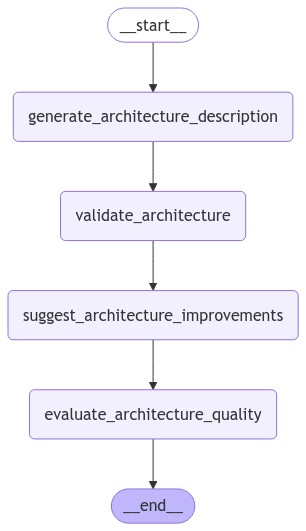

In [78]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [79]:
import requests

image_url = "https://raw.githubusercontent.com/AaronSosaRamos/mission-flights/main/files-for-test/software_architecture_example.jpeg"
content = requests.get(image_url).content

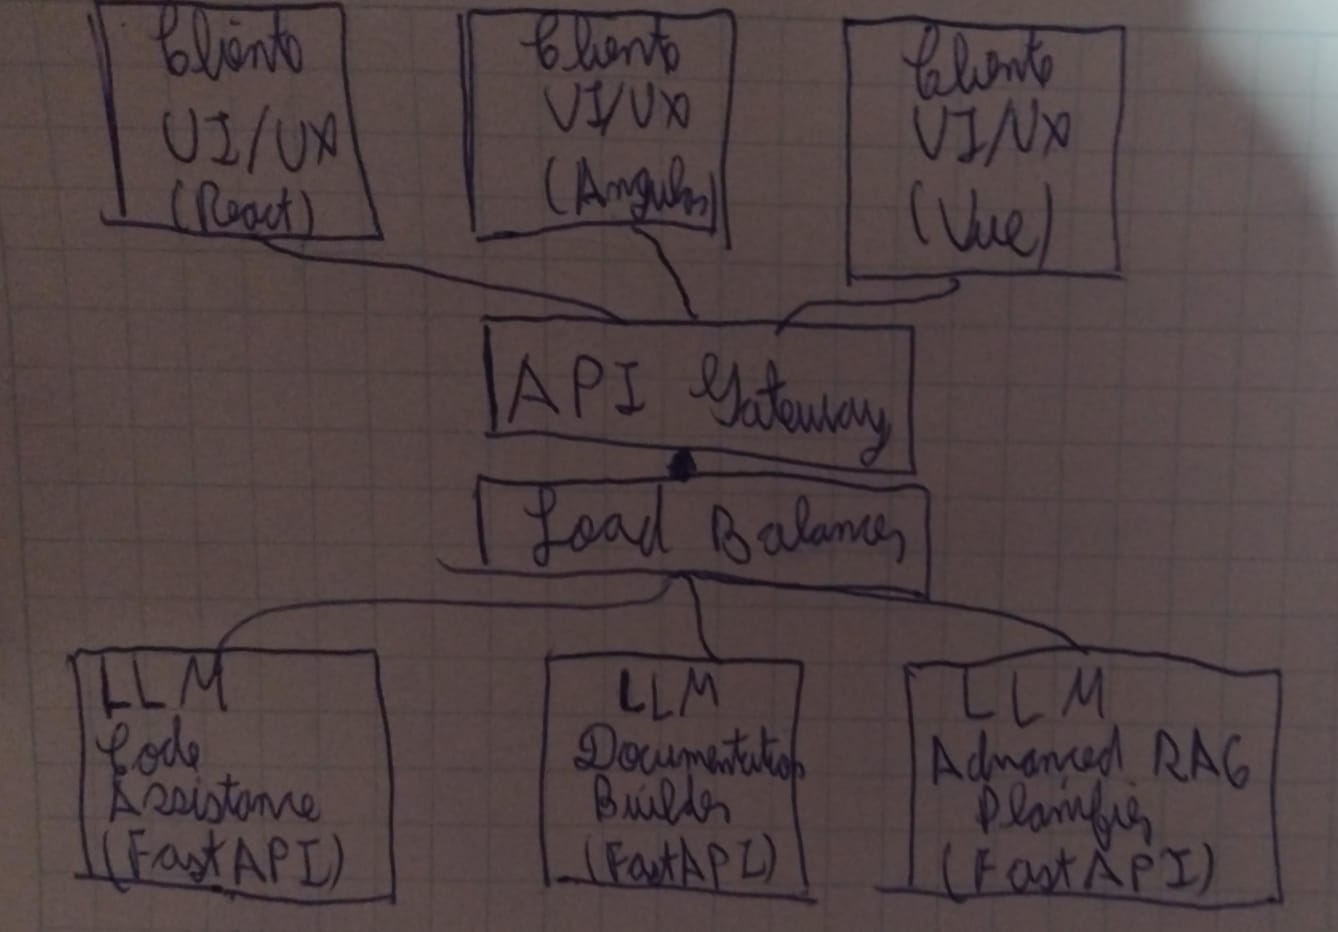

In [80]:
from IPython.display import Image
Image(content)

In [81]:
#inputs = {
#    "img_url": "https://raw.githubusercontent.com/AaronSosaRamos/mission-flights/main/files-for-test/software_architecture_example.jpeg",
#    "requirements": """
#    Cross-platform support: The system must allow React, Angular, and Vue clients to interact with the backend seamlessly.

#    Load balancing: The API Gateway should distribute requests evenly among the LLM services.

#    LLM interoperability: The LLM services (Code Assistant, Documentation Builder, and Advanced RAG) must be accessible and function correctly via FastAPI.

#    Scalability: The architecture should handle increases in user or request volume without performance degradation.

#    API security: The system must ensure secure authentication and authorization for users accessing the services.
#    """,
#    "lang": "en"
#    ""}

#result = app.invoke(inputs)

In [82]:
inputs = {
    "img_url": "https://raw.githubusercontent.com/AaronSosaRamos/mission-flights/main/files-for-test/software_architecture_example.jpeg",
    "requirements": """
Soporte multiplataforma: El sistema debe permitir que los clientes de React, Angular y Vue interactúen con el backend sin problemas.

Balanceo de carga: El API Gateway debe distribuir las solicitudes de manera equitativa entre los servicios LLM.

Interoperabilidad de LLM: Los servicios LLM (Asistente de Código, Generador de Documentación y RAG Avanzado) deben ser accesibles y funcionar correctamente a través de FastAPI.

Escalabilidad: La arquitectura debe manejar aumentos en el volumen de usuarios o solicitudes sin degradar el rendimiento.

Seguridad de la API: El sistema debe garantizar una autenticación y autorización seguras para los usuarios que acceden a los servicios.
    """,
    "lang": "es"
    ""}

result = app.invoke(inputs)

Architecture Description: {'architecture_name': 'Microservices', 'layers': ['Presentation', 'API Gateway', 'Business Logic', 'Data'], 'components': [{'name': 'Cliente UI/UX (React)', 'description': 'Interfaz de usuario del cliente, construida con React.', 'dependencies': ['API Gateway'], 'type_component': 'Service', 'exposed_endpoints': None, 'input_data': None, 'output_data': ['Solicitudes a la API']}, {'name': 'Cliente VI/UX (Angular)', 'description': 'Interfaz de usuario del cliente, construida con Angular.', 'dependencies': ['API Gateway'], 'type_component': 'Service', 'exposed_endpoints': None, 'input_data': None, 'output_data': ['Solicitudes a la API']}, {'name': 'Cliente VI/UX (Vue)', 'description': 'Interfaz de usuario del cliente, construida con Vue.', 'dependencies': ['API Gateway'], 'type_component': 'Service', 'exposed_endpoints': None, 'input_data': None, 'output_data': ['Solicitudes a la API']}, {'name': 'API Gateway', 'description': 'Punto de entrada único para las solic

In [83]:
result

{'img_url': 'https://raw.githubusercontent.com/AaronSosaRamos/mission-flights/main/files-for-test/software_architecture_example.jpeg',
 'requirements': '\nSoporte multiplataforma: El sistema debe permitir que los clientes de React, Angular y Vue interactúen con el backend sin problemas.\n\nBalanceo de carga: El API Gateway debe distribuir las solicitudes de manera equitativa entre los servicios LLM.\n\nInteroperabilidad de LLM: Los servicios LLM (Asistente de Código, Generador de Documentación y RAG Avanzado) deben ser accesibles y funcionar correctamente a través de FastAPI.\n\nEscalabilidad: La arquitectura debe manejar aumentos en el volumen de usuarios o solicitudes sin degradar el rendimiento.\n\nSeguridad de la API: El sistema debe garantizar una autenticación y autorización seguras para los usuarios que acceden a los servicios.\n    ',
 'lang': 'es',
 'detected_architecture': {'architecture_name': 'Microservices',
  'layers': ['Presentation', 'API Gateway', 'Business Logic', 'Da